C:\Users\User\anaconda3\New folder\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\User\anaconda3\New folder\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\User\anaconda3\New folder\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\User\anaconda3\New folder\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\User\anaconda3\New folder\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\User\anaconda3\Ne

Best: Ridge | Test R2: 0.8041


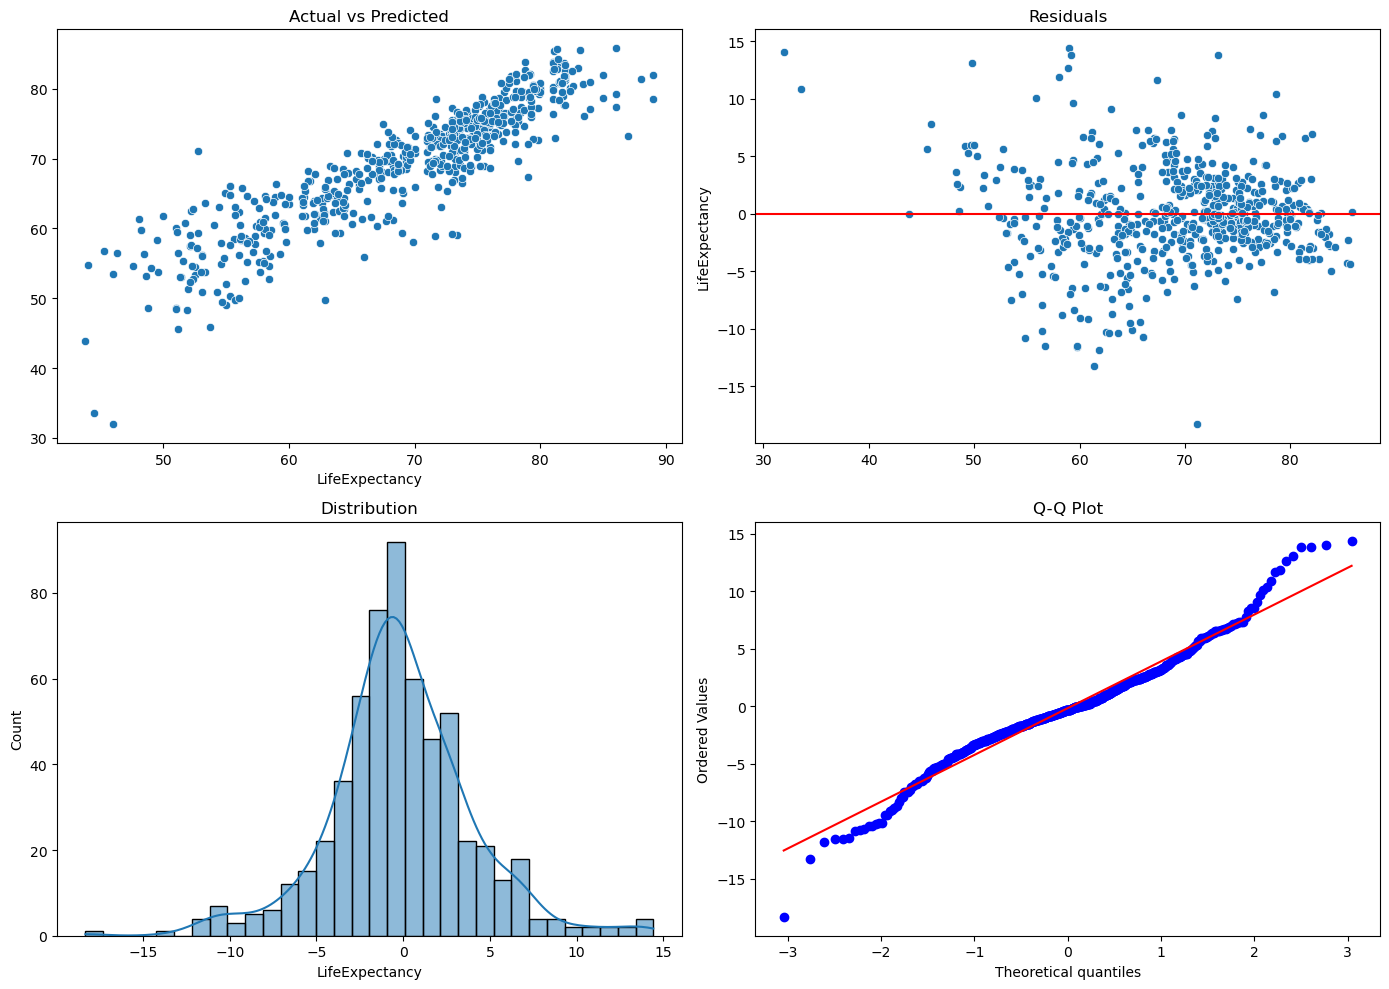

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats

# Custom VIF Selector Class for Pipeline Integration
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0):
        self.threshold = threshold
        self.selected_features_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if isinstance(X, np.ndarray) else X
        curr_features = list(X_df.columns)
        while len(curr_features) > 1:
            X_const = sm.add_constant(X_df[curr_features])
            vif_vals = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
            vif_series = pd.Series(vif_vals, index=X_const.columns).drop('const')
            if vif_series.max() > self.threshold or np.isinf(vif_series.max()):
                curr_features.remove(vif_series.idxmax())
            else: break
        self.selected_features_ = curr_features
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X) if isinstance(X, np.ndarray) else X
        return X_df[self.selected_features_]

# 1. Setup & Imputation
train_df, test_df = pd.read_csv('life_expectancy_train_master.csv'), pd.read_csv('life_expectancy_test_master.csv')
target = 'LifeExpectancy'
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

# 2. Outlier Removal (Cook's Distance)
ols = sm.OLS(y_train, sm.add_constant(X_train_imp)).fit()
mask = ols.get_influence().cooks_distance[0] < (4 / len(X_train_imp))
X_train_c, y_train_c = X_train_imp[mask].reset_index(drop=True), y_train[mask].reset_index(drop=True)

# 3. Best Model Selection (Pipeline prevents leakage)
models = {"Linear": LinearRegression(), "Ridge": Ridge(), "Lasso": Lasso(alpha=0.1)}
best_name, best_score, best_pipe = "", -np.inf, None
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([('vif', VIFSelector()), ('scaler', StandardScaler()), ('reg', model)])
    score = cross_val_score(pipe, X_train_c, y_train_c, cv=kf, scoring='r2').mean()
    if score > best_score: best_score, best_name, best_pipe = score, name, pipe

# 4. Final Fit & Evaluation
best_pipe.fit(X_train_c, y_train_c)
y_pred = best_pipe.predict(X_test_imp)
print(f"Best: {best_name} | Test R2: {r2_score(y_test, y_pred):.4f}")

# 5. Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
res = y_test - y_pred
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0,0]); axes[0,0].set_title('Actual vs Predicted')
sns.scatterplot(x=y_pred, y=res, ax=axes[0,1]); axes[0,1].axhline(0, color='r'); axes[0,1].set_title('Residuals')
sns.histplot(res, kde=True, ax=axes[1,0]); axes[1,0].set_title('Distribution')
stats.probplot(res, dist="norm", plot=axes[1,1]); axes[1,1].set_title('Q-Q Plot')
plt.tight_layout(); plt.show()